# CIFAR-10 Dataset
- CIFAR-10 데이터 세트는 32x32 크기의 컬러 이미지로 10개 클래스를 가진 60,000개의 이미지이다.
    - Train image : 50,000
    - Test image : 10,000

![image-2.png](attachment:image-2.png)

### module import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-white')

### 전처리 설정

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                  # pixel value를 0 ~ 1 사이 값으로 변환
    transforms.Normalize((0.5, ), (0.5, ))  # 0 ~ 1 사이로 변환된 pixel value를 -1 ~ 1 사이로 변환
])

In [ ]:
trainset = torchvision.datasets.CIFAR10('./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10('./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)

In [ ]:
labels_name = {num : label for num, label in enumerate(trainset.classes)}
labels_name

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
def imshow(images):
    images = images / 2 + 0.5 # Nomarlize된 데이터를 다시 ToTensor로 변환
    npimg = images.numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

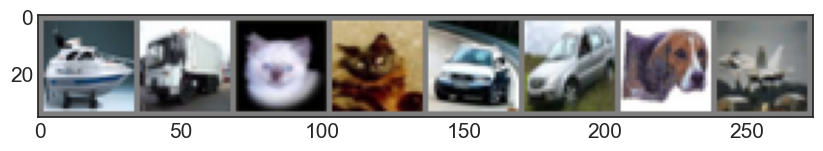

tensor([8, 9, 3, 3, 1, 1, 5, 0])
['ship', 'truck', 'cat', 'cat', 'automobile', 'automobile', 'dog', 'airplane']


In [ ]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))
print(labels[:8])
print([labels_name[label.item()] for label in labels[:8]])

### 모델 생성

In [ ]:
class CIFARNet(nn.Module):
    
    def __init__(self):
        super(CIFARNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
        # self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        
        return x

##### GPU 설정

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = CIFARNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 학습

In [ ]:
def train(model, train_loader, optimizer, losses, corrects):
    model.train()
    correct = 0
    total = len(train_loader.dataset)
    for batch, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred_label = model(image)
        
        _, predicted = torch.max(pred_label.data, 1)
        correct += (predicted == label).sum().item()
        
        loss = criterion(pred_label, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if not(batch % 100):
            print(f"Train Epoch : {batch * len(image)} / {len(train_loader.dataset)} | Train Loss : {loss.item():.4f}")
    correct = 100 * correct / total
    corrects.append(100 * correct / total)
    print(f"Train Accuracy : {correct:.2f}")

### 테스트

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for image, label in test_loader:
            image, label = image.to(device), label.to(device)
            pred_label = model(image)
            test_loss += criterion(pred_label, label).item()
            _, predicted = torch.max(pred_label.data, 1)
            
            correct += (predicted == label).sum().item()
            
    test_loss /= total
    correct = 100 * correct / total
            
    return test_loss, correct

In [ ]:
epochs = 100
losses = []
corrects = []
for epoch in range(epochs):
    train(model, train_loader, optimizer, losses, corrects)
    test_loss, correct = test(model, test_loader)
    print(f"Epoch : {epoch + 1} | Test Loss : {test_loss:.4f} | Test Accuracy : {correct:.2f}")

Train Epoch : 0 / 50000 | Train Loss : 2.304221
Train Epoch : 12800 / 50000 | Train Loss : 1.760484
Train Epoch : 25600 / 50000 | Train Loss : 1.554922
Train Epoch : 38400 / 50000 | Train Loss : 1.431060
Train Accuracy : 41.70
Epoch : 1 | Test Loss : 0.0096 | Test Accuracy : 55.32
Train Epoch : 0 / 50000 | Train Loss : 1.146643
Train Epoch : 12800 / 50000 | Train Loss : 1.249120
Train Epoch : 25600 / 50000 | Train Loss : 1.042754
Train Epoch : 38400 / 50000 | Train Loss : 0.897631
Train Accuracy : 58.55
Epoch : 2 | Test Loss : 0.0084 | Test Accuracy : 61.54
Train Epoch : 0 / 50000 | Train Loss : 1.134720
Train Epoch : 12800 / 50000 | Train Loss : 0.834663
Train Epoch : 25600 / 50000 | Train Loss : 0.930540
Train Epoch : 38400 / 50000 | Train Loss : 0.934835
Train Accuracy : 66.47
Epoch : 3 | Test Loss : 0.0072 | Test Accuracy : 67.41
Train Epoch : 0 / 50000 | Train Loss : 0.821907
Train Epoch : 12800 / 50000 | Train Loss : 0.820483
Train Epoch : 25600 / 50000 | Train Loss : 1.060618
Tr